## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at depths chosen by the SED-SVD technique and others in order to compare them. Finally, the predicted data from the optimal layer is selected.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from __future__ import division
from coord import GGS
from equiv_layer import EqLayer
from normal_grav import Norm_Grav
from map_plot import grid_map
import config_style_plot as style
import numpy.testing as npt

# Redefining functions
closedform = Norm_Grav().closedform
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

### Importing observational points (planimetric only)

In [3]:
# IMPORTING BDG FILE
path = '../data/ICGEM/'
uf = 'EIGEN'
name_bdg = '_RJ.gdf'
lon, lat, grav = np.loadtxt('{p}{u}{nb}'.format(p=path,u=uf,nb=name_bdg), skiprows=34, unpack=True)
lon = lon-360.
alt = np.zeros_like(lon)+3000.

# Calculating gamma
gamma = closedform(alt, lat)

# Obtaining short wavelength signals
disturb = grav - gamma
print disturb.size, grav[0], gamma[0], disturb[0]
print lon.size, lat.size, alt.size#, h_eigen.size

6461 977758.054217 977740.578178 17.4760389588
6461 6461 6461


In [4]:
tobedel = np.where(np.abs(disturb)>100.)[0]
print tobedel.size, tobedel, disturb[tobedel], alt[tobedel]

4 [  63   64 3373 3374] [ 100.81761758  125.55657753  107.98410425  105.85473479] [ 3000.  3000.  3000.  3000.]


In [5]:
# disturb = np.delete(disturb, tobedel)
# lon = np.delete(lon, tobedel)
# lat = np.delete(lat, tobedel)
# alt = np.delete(alt, tobedel)
print disturb.size, lon.size, lat.size, alt.size

6461 6461 6461 6461


In [6]:
# CHANGE ALTITUDE UNITS ON MAP
# grid_map(lon, lat, alt, alt, uf, cmap='terrain', edges=(-45.5,-40.9,-23.6,-20.4), \
#           center=(-22.8, -21.6,-42.8), drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), \
#           residual=True, fig_size=(9.,10.))#, save=name)

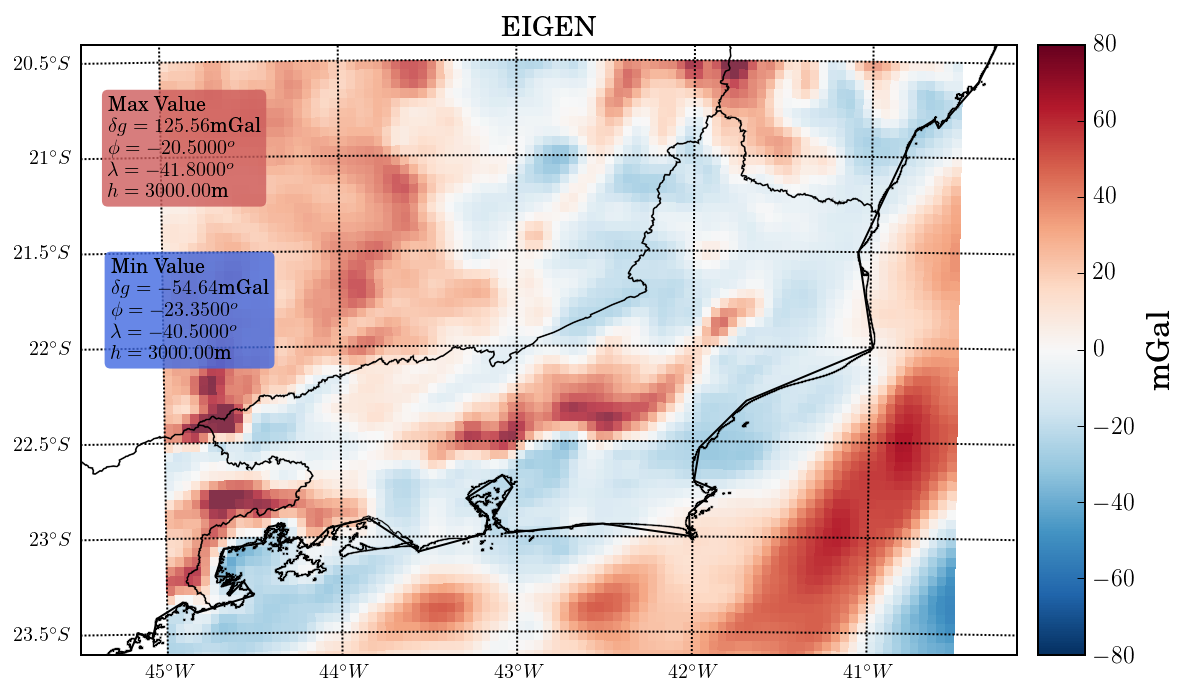

In [7]:
grid_map(lon, lat, alt, disturb, uf, edges=(-45.5,-40.2,-23.6,-20.4), \
          center=(-22.8, -21.6,-42.8), drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), \
         fig_size=(9.,10.), lim_val=(True,80) )#, save=name)

### Calculating rotation matrices and Cartesian coordinates

In [8]:
# Calculating Cartesian coordinates
x, y, z = geodetic2cartesian(lon, lat, alt)
R = np.array(rotation_matrix(lon, lat))

## Estimativa das camadas locais

In [9]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5

In [10]:
latc = []
lonc = []

## Iteração 1 - A0

In [11]:
indl = np.arange(disturb.size)
mi_c = 1e-5
hcl = 2000 #5000. #14200. # 20000. #800. #1000.
print hcl, type(indl), #indl

2000 <type 'numpy.ndarray'>


In [12]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = lat[indl]
loncl = lon[indl]

In [13]:
Rcl = R[:, indl]

In [14]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
Lay = EqLayer(lon, lat, np.zeros_like(lon)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print Acc_l.shape

(6461, 6461)


In [15]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [16]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print p_L2.size
p_L1 = L1_estim(rcl, p_L2, Acc_l, 3)

6461


In [17]:
rcl -= np.dot(Acc_l, p_L1)
# print rcl[:50]

In [18]:
indexing = np.where(rcl==np.max(rcl))[0]
index = np.where(disturb==np.max(disturb))[0]
print 'MAX FOR RESIDUALS'
print rcl[indexing], disturb[indexing], np.dot(Acc_l, p_L2)[indexing]
print 'MAX FOR DISTURB'
print rcl[index], disturb[index], np.dot(Acc_l, p_L2)[index]

MAX FOR RESIDUALS
[  1.89714910e-12] [ 57.98032274] [ 57.98021532]
MAX FOR DISTURB
[ -7.10542736e-14] [ 125.55657753] [ 125.55574339]


In [19]:
print np.std(rcl)

2.46128146081e-13


In [20]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

1.8971491044794675e-12

In [21]:
print rabs_max, rabs_max_l

[] 1.89714910448e-12


In [22]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)

In [23]:
latc.append(latcl)
lonc.append(loncl)

In [24]:
rabs_max.append(rabs_max_l)

In [25]:
rc = rcl[:] #r1

In [26]:
print np.max(np.abs(rc))

1.89714910448e-12


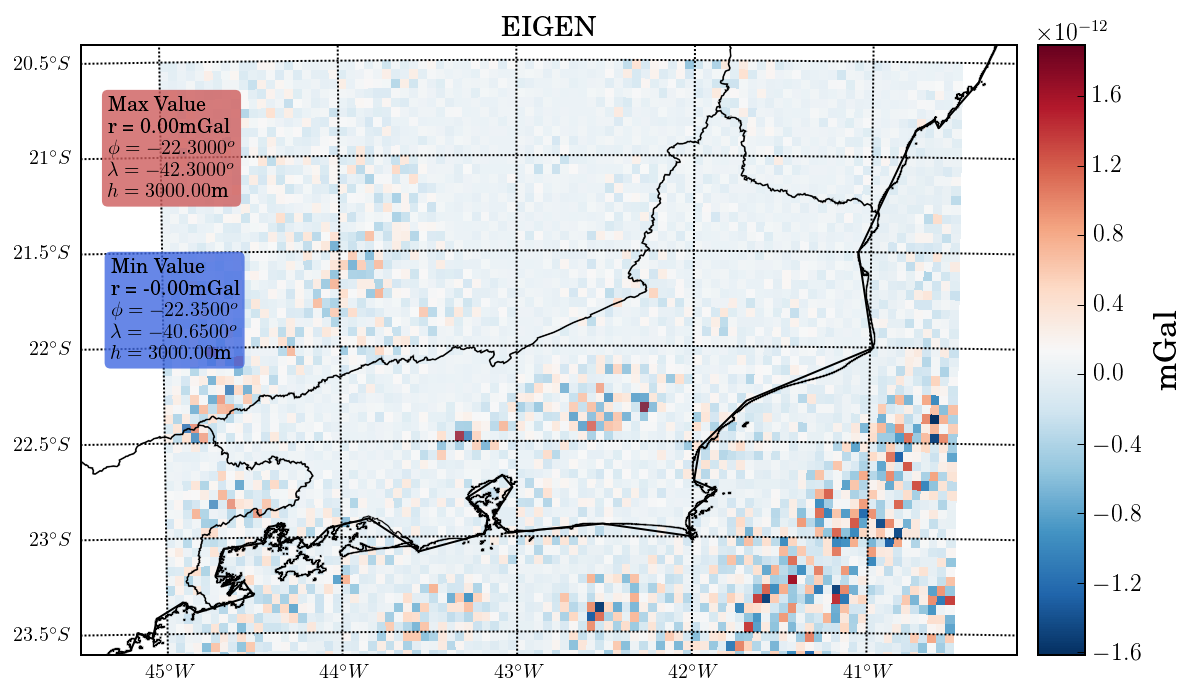

In [27]:
# Residual
grid_map(lon, lat, alt, rc, uf, edges=(-45.5,-40.2,-23.6,-20.4), center=(-22.8, -21.6,-42.8), \
         drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), residual=True, fig_size=(9.,10.))#, save=name)

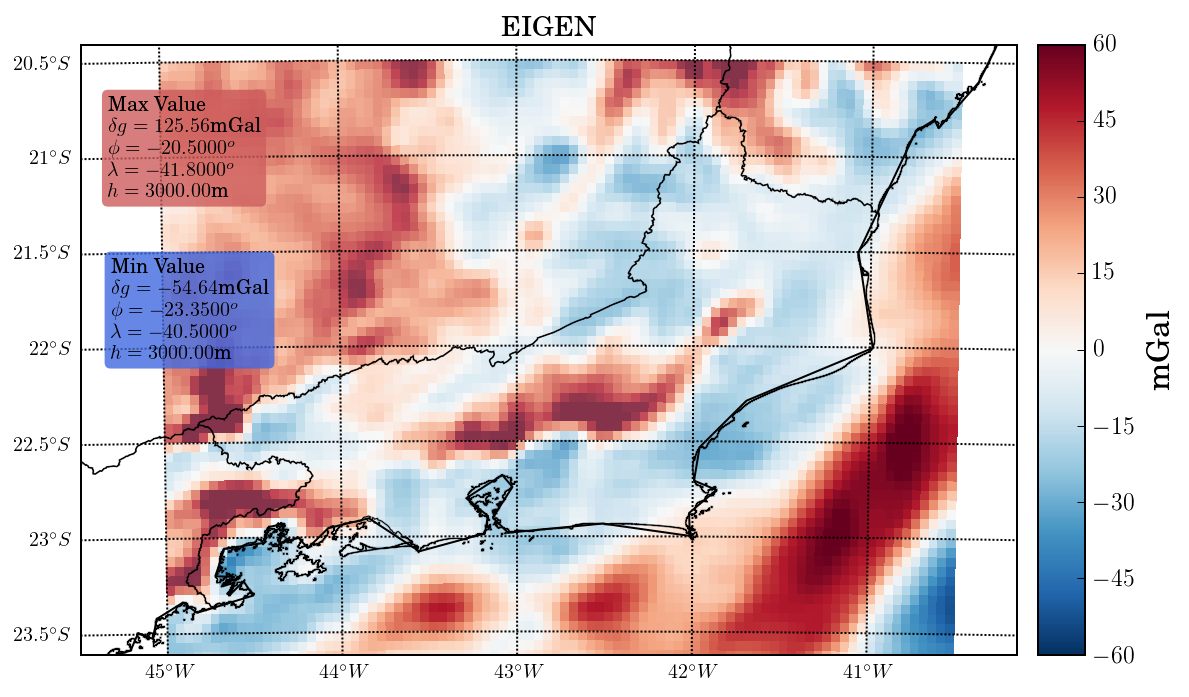

In [28]:
# Observed data
grid_map(lon, lat, alt, disturb, uf, edges=(-45.5,-40.2,-23.6,-20.4), center=(-22.8, -21.6,-42.8), \
         drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), lim_val=(True,60), \
         fig_size=(9.,10.))#, save=name)

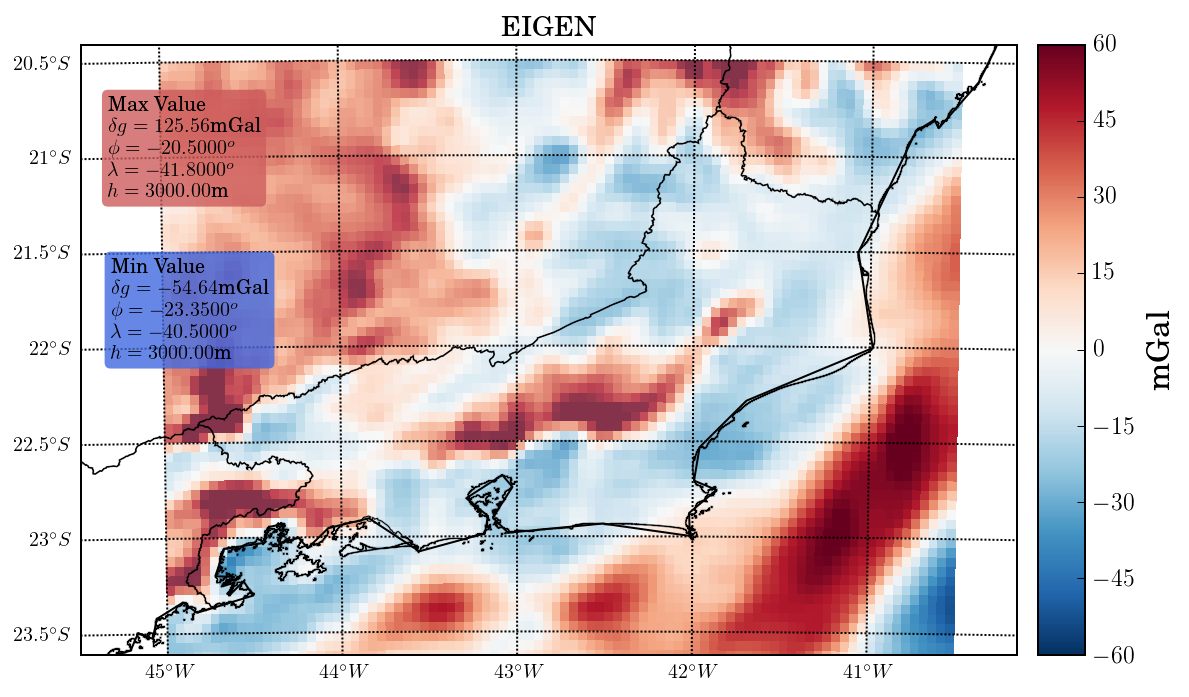

In [29]:
# Predicted data
grid_map(lon, lat, alt, np.dot(Acc_l, p_L1), uf, edges=(-45.5,-40.2,-23.6,-20.4), \
         center=(-22.8, -21.6,-42.8), drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), \
         lim_val=(True,60), fig_size=(9.,10.))#, save=name)

In [30]:
ind_ = np.where(np.abs(rc) >= 1e-5)[0]
print ind_.size, p_L2.size

0 6461
